<a href="https://colab.research.google.com/github/giovanimachado/phd-puc/blob/main/logica-fuzzy/LogicaFuzzy_Trabalho1_Giovani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Cristian Muñoz Villalobos <br>
Edapted by Giovani F. Machado



In [ ]:
#!wget https://raw.githubusercontent.com/crismunoz/Fuzzy-Logic/master/6_RulesExtraction/Dolar.txt
!wget https://raw.githubusercontent.com/crismunoz/Fuzzy-Logic/master/6_RulesExtraction/fuzzy_rules.py
!pip install scikit-fuzzy

--2020-11-16 00:11:50--  https://raw.githubusercontent.com/crismunoz/Fuzzy-Logic/master/6_RulesExtraction/fuzzy_rules.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4794 (4.7K) [text/plain]
Saving to: ‘fuzzy_rules.py’

fuzzy_rules.py      100%[===================>]   4.68K  --.-KB/s    in 0s      

2020-11-16 00:11:51 (30.8 MB/s) - ‘fuzzy_rules.py’ saved [4794/4794]



In [ ]:
from datetime import timedelta, date
from operator import itemgetter
from itertools import groupby

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pprint
import os

import skfuzzy as fuzz
from skfuzzy import control as ctrl
from fuzzy_rules import extract_rules,config_input_variable,config_output_variable,define_input_variables,define_output_variables,read_dataset

from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split

# Read data with format (tab separator): 

In [ ]:
cat EmpresaX.txt | head -5 

0,4290
0,4430
0,4510
0,4550
0,4400


Text(0, 0.5, 'value')

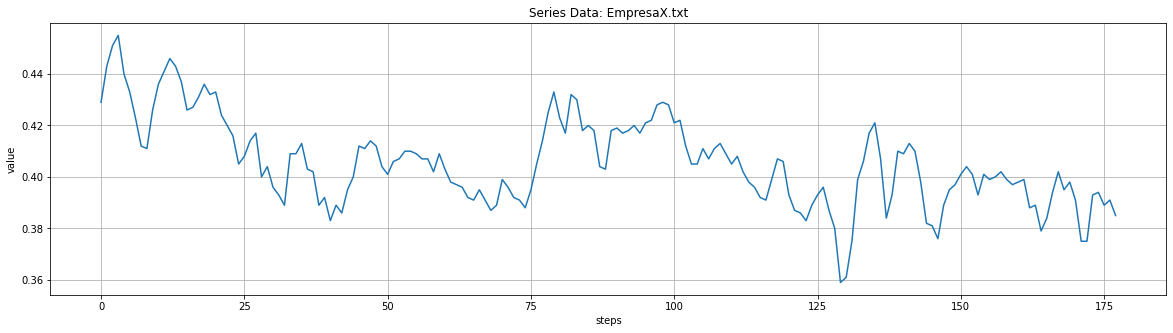

In [ ]:
file_path='EmpresaX.txt'
data = read_dataset(file_path)
plt.figure(figsize=(20,5))
plt.title('Series Data: {}'.format(file_path))
plt.plot(data)
plt.grid()
plt.xlabel('steps')
plt.ylabel('value')

# Parameters definition

In [ ]:
steps_forward=1
windows_size=6
nInputs_sets=3
nOutputs_sets=7
# nb_inputs: Number of input variable
# nb_outputs: Number of output variables

# Preprocessing Data

In [ ]:
steps_forward=steps_forward
windows_size=windows_size
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.window(windows_size + steps_forward, shift=1, drop_remainder=True)
dataset = np.stack([list(window_dataset) for window_dataset in dataset], axis=0)
X,y_true = dataset[:,:-steps_forward,0],dataset[:,-steps_forward:][:,-1,:]
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.20, shuffle=False)

print('-'*21+'\nDataset Distribution\n'+'-'*21)
print('X\t:{} | y_true\t:{}'.format(X.shape,y_true.shape))
print('X_train\t:{} | y_train\t:{}'.format(X_train.shape,y_train.shape))
print('X_test\t:{}  | y_test\t:{}'.format(X_test.shape,y_test.shape))

---------------------
Dataset Distribution
---------------------
X	:(172, 6) | y_true	:(172, 1)
X_train	:(137, 6) | y_train	:(137, 1)
X_test	:(35, 6)  | y_test	:(35, 1)


# Configuration

## Variable Parameters
- nb_inputs: Number of input variable
- nb_outputs: Number of output variables
- nb_sets: Number of fuzzy set by variable
- min : list of min value for each variables
- max : list of max value for each variables
- shoulder : The first and last set are trapezoidal function

## Fuzzy System Parameters
- defuzzify_method: Controls which defuzzification method will be used. 
    - 'centroid': Centroid of area 
    - 'bisector': bisector of area 
    - 'mom' : mean of maximum 
    - 'som' : min of maximum 
    - 'lom' : max of maximum
- aggregation_opt: mathematic function for OR and AND operation

## Other Parameters (optional)
- resolution: number of points in discret domain for each I/O variable.
- epsilon: gap for min value (min - epsilon) and max value (max + epsilon)

In [ ]:
x_min_value = X.min(axis=0)
x_max_value = X.max(axis=0)
y_min_value = y_true.min(axis=0)
y_max_value = y_true.max(axis=0)

nb_inputs = X_train.shape[-1]
nb_outputs = y_train.shape[-1]

aggregation_opt={
'and_func':np.fmin,
'or_func': np.fmax
}

config = {
    
# Variable Parameters
'nb_inputs' : nb_inputs,
'nb_outputs': nb_outputs,
'nb_sets':[[nInputs_sets]*nb_inputs, [nOutputs_sets]*nb_outputs],
'min':[x_min_value,y_min_value],
'max':[x_max_value,y_max_value],
'shoulder':True,

# Fuzzy System Parameters
'defuzzify_method':'bisector',
'aggregation_opt': aggregation_opt,

#Other Parametres
'resolution':1000,
'epsilon':0.0001
}

pp = pprint.PrettyPrinter(depth=6)
pp.pprint(config)
pp.pprint(aggregation_opt)

{'aggregation_opt': {'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>},
 'defuzzify_method': 'bisector',
 'epsilon': 0.0001,
 'max': [array([0.455, 0.455, 0.455, 0.455, 0.446, 0.446]), array([0.446])],
 'min': [array([0.359, 0.359, 0.359, 0.359, 0.359, 0.359]), array([0.359])],
 'nb_inputs': 6,
 'nb_outputs': 1,
 'nb_sets': [[3, 3, 3, 3, 3, 3], [7]],
 'resolution': 1000,
 'shoulder': True}
{'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>}


In [ ]:
type(config)

dict

In [ ]:
antecedents = define_input_variables(config, shoulder=config['shoulder'])
consequents = define_output_variables(config, shoulder=config['shoulder'], defuzzify_method=config['defuzzify_method'])
print(antecedents)
print(consequents)

[Antecedent: I_1, Antecedent: I_2, Antecedent: I_3, Antecedent: I_4, Antecedent: I_5, Antecedent: I_6]
[Consequent: O_1]


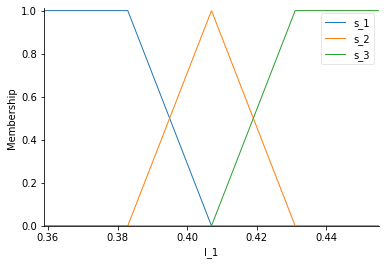

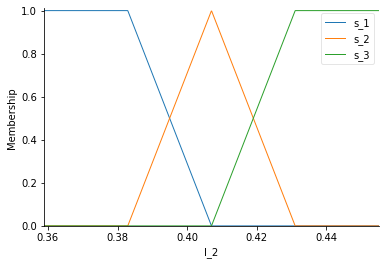

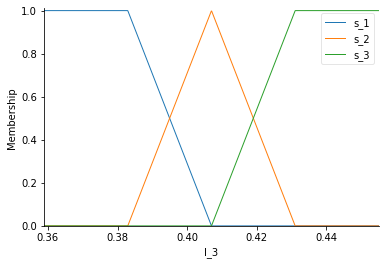

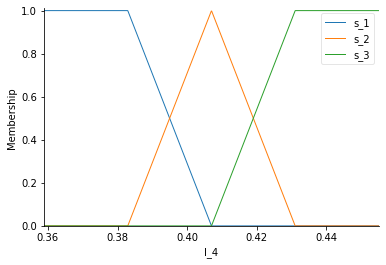

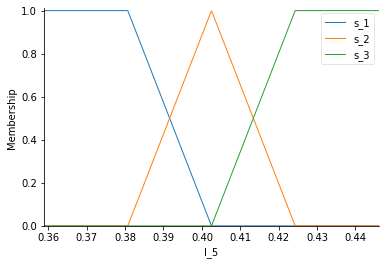

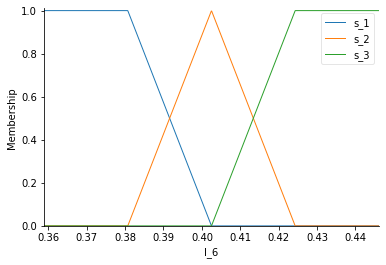

In [ ]:
for i in range(len(antecedents)):
  antecedents[i].view()

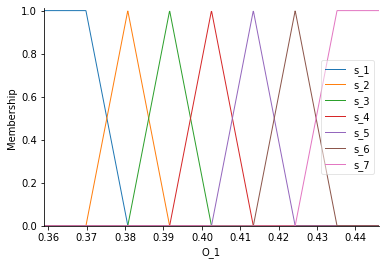

In [ ]:
for i in range(len(consequents)):
  consequents[i].view()

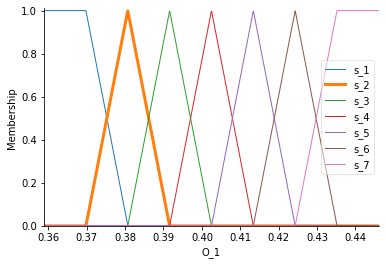

In [ ]:
consequents[0]['s_2'].view()

In [ ]:
fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_1'].mf , .4)

0.29106029106029113

In [ ]:
# variables
# data = np.concatenate([X_train,y_train],axis=1)
# data

In [ ]:
# for x,var in zip(data[0], variables):
#   print((x, var.universe))

In [ ]:
# variables = antecedents + consequents
# data = np.concatenate([X_train,y_train],axis=1)
#   # all_rule_candidate = []
# for instance in data:
#   #   rule_candidate = []
#     for x,var in zip(instance,variables):
#       print('x is {}'.format(x))
#       print('var is {}'.format(var))
#       print('var[terms] is {}'.format(var.terms))
#       print('term is {}'.format)
#       print('var.universe {}'.format(var.universe))
#       #u_x_s = [fuzz.interp_membership(var.universe, var[term].mf, x)  for term in var.terms]
#       u_x_s = [fuzz.interp_membership(var.universe, var[term].mf, .4)  for term in var.terms]
#       # term_max = np.argmax(u_x_s)
#       # print(term_max)
# # fuzz.interp_membership(var.universe, antecedents[0]['s_1'].mf , .4)
# # #antecedents[0]['s_1']
# # print(len(var.universe))
# # print(len(antecedents[0]['s_1'].mf))


In [ ]:
rules,df_rules = extract_rules(config, antecedents, consequents, X_train, y_train)
print('number of rules:', len(df_rules))

number of rules: 61


In [ ]:
df_rules.head(10)

,I_1,I_2,I_3,I_4,I_5,I_6,O_1,Dr
0,s_1,s_1,s_1,s_1,s_1,s_2,s_4,0.473931
1,s_1,s_1,s_1,s_1,s_2,s_1,s_2,0.177278
2,s_1,s_1,s_1,s_1,s_2,s_2,s_5,0.471939
3,s_1,s_1,s_1,s_2,s_1,s_1,s_1,0.167740
4,s_1,s_1,s_1,s_2,s_2,s_2,s_5,0.127283
5,s_1,s_1,s_1,s_2,s_2,s_3,s_6,0.259808
6,s_1,s_1,s_2,s_1,s_1,s_1,s_1,0.196599
7,s_1,s_1,s_2,s_2,s_2,s_1,s_3,0.041275
8,s_1,s_1,s_2,s_2,s_2,s_2,s_4,0.176974
9,s_1,s_1,s_2,s_2,s_3,s_3,s_4,0.211981


In [ ]:
%time system = ctrl.ControlSystem(rules)

CPU times: user 2.24 s, sys: 16.8 ms, total: 2.25 s
Wall time: 2.26 s


In [ ]:
%time sim = ctrl.ControlSystemSimulation(system)

CPU times: user 211 µs, sys: 12 µs, total: 223 µs
Wall time: 245 µs


In [ ]:
def evaluate_model(sim, x_data, y_data, return_results=False):
  y_prev = []
  for x in x_data:
      for i,x_i in enumerate(x,1):
          sim.input['I_{}'.format(i)]=x_i
      sim.compute()
      result = sim.output['O_1']
      y_prev.append(result)
      
  mse = mean_squared_error(y_data, y_prev)
  
  print('mean_squared_error: {}'.format(mse))

  plt.figure(figsize=(15,5))
  plt.plot(y_data,'*')
  plt.plot(y_prev,'s')
  plt.show()

  y_data, y_prev = np.squeeze(np.array(y_data)), np.array(y_prev)
  table_results = pd.DataFrame()
  table_results['Real']=y_data
  table_results['Predicted']=y_prev
  table_results['Diference']=np.abs(y_data - y_prev) 
  table_results['Diference (%)']=np.abs((y_data - y_prev) / y_data)
  if return_results:
    return table_results

mean_squared_error: 5.507912612048953e-05


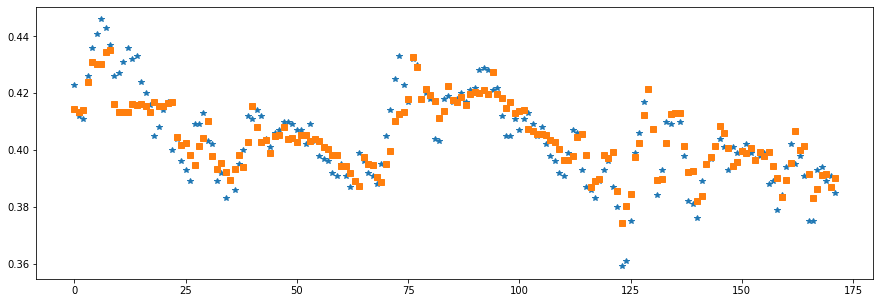

In [ ]:
results=evaluate_model(sim, X, y_true, return_results=True)

In [ ]:
results.head()

,Real,Predicted,Diference,Diference (%)
0,0.423,0.414394,0.008606,0.020345
1,0.412,0.413400,0.001400,0.003398
2,0.411,0.413976,0.002976,0.007241
3,0.426,0.423865,0.002135,0.005012
4,0.436,0.430868,0.005132,0.011772


mean_squared_error: 5.796840992264687e-05


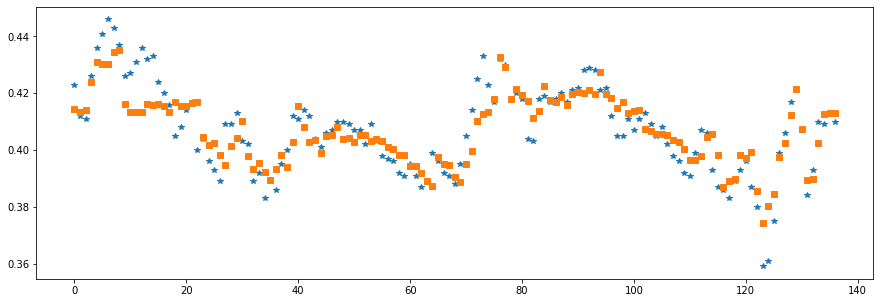

In [ ]:
evaluate_model(sim, X_train, y_train)

mean_squared_error: 4.376964380918792e-05


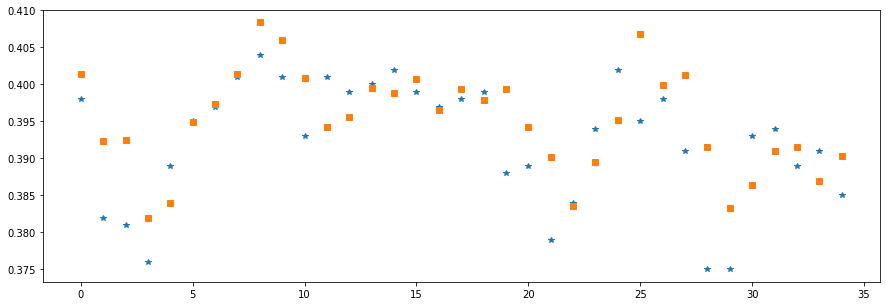

In [ ]:
evaluate_model(sim, X_test, y_test)

# Questão 1) 
Para a série acima, deseja-se realizar uma previsão de um passo a frente, por
meio de um sistema de inferência fuzzy (SIF). Para tal, é necessário efetuar uma
extração de regras a partir dos dados fornecidos utilizando o método de Wang &
Mendel. Construa este SIF fazendo uso do aplicativo Fuzzy Rules ou da sua
versão em Python. Em busca do melhor desempenho possível, realize
alterações no número de conjuntos fuzzy, no tamanho da janela e nas operações
de interseção dos antecedentes, implicação e defuzzificação.

Resposta: 
Foram realizadas várias tentativas variando os parâmetros do sistema Fuzzy. Os melhores resultados foram encontrados utilizando 3 conjuntos para as varíaveis de entrada e 7 para a de saída. Abaixo estão descritas as 3 melhores configurações. Sendo a **Test 3** a melhor delas.

Test 1

```
{'aggregation_opt': {'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>},
 'defuzzify_method': 'mom',
 'epsilon': 0.0001,
 'max': [array([0.455, 0.455, 0.455, 0.455, 0.446, 0.446]), array([0.446])],
 'min': [array([0.359, 0.359, 0.359, 0.359, 0.359, 0.359]), array([0.359])],
 'nb_inputs': 6,
 'nb_outputs': 1,
 'nb_sets': [[3, 3, 3, 3, 3, 3], [7]],
 'resolution': 1000,
 'shoulder': True}
{'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>}
```
Result_train: 8.56939685890817e-05 <br>
Result_test: mean_squared_error: 8.460339389600714e-05 <br>

---

Test 2

```
{'aggregation_opt': {'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>},
 'defuzzify_method': 'bisector',
 'epsilon': 0.0001,
 'max': [array([0.455, 0.455, 0.455, 0.455, 0.446, 0.446]), array([0.446])],
 'min': [array([0.359, 0.359, 0.359, 0.359, 0.359, 0.359]), array([0.359])],
 'nb_inputs': 6,
 'nb_outputs': 1,
 'nb_sets': [[3, 3, 3, 3, 3, 3], [7]],
 'resolution': 1000,
 'shoulder': True}
{'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>}
```
Result_train: 6.542768997016898e-05 <br>
Result_test: mean_squared_error: 4.382474941088625e-05 <br>


---

**Test 3**

```
{'aggregation_opt': {'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>},
 'defuzzify_method': 'bisector',
 'epsilon': 0.0001,
 'max': [array([0.455, 0.455, 0.455, 0.455, 0.446, 0.446]), array([0.446])],
 'min': [array([0.359, 0.359, 0.359, 0.359, 0.359, 0.359]), array([0.359])],
 'nb_inputs': 6,
 'nb_outputs': 1,
 'nb_sets': [[3, 3, 3, 3, 3, 3], [7]],
 'resolution': 1000,
 'shoulder': True}
{'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>}
```
Result_train: 5.796840992264687e-05 <br>
Result_test: mean_squared_error: 4.376964380918792e-05 <br>


---

# Questão 2) 
Tomando por base a melhor configuração obtida em (1), realize um passo a
passo manual do procedimento de extração de regras para os dez primeiros
dados.

###Passo 1

Neste primeiro passo todo o código será explorado em detalhes. Como foi solicitado que o procedimento fosse realizado de maneira manual, o notebook foi utilizado apenas como calculadora e entrega do trabalho. O código não foi otimizado.

In [ ]:
data[:10]

array([[0.429],
       [0.443],
       [0.451],
       [0.455],
       [0.44 ],
       [0.433],
       [0.423],
       [0.412],
       [0.411],
       [0.426]])

In [ ]:
# criando uma lista para gravar as maiores pertinências
rule1_val = []
rule1_set = []

<center>

**j = 0** <br>
</center>
<br>
Janela posicionada do primeiro ao sexto elemento, o consequente está associado ao sétimo elemento.

Primeiro elemento

Plotando os conjunto Fuzzy da entrada 1

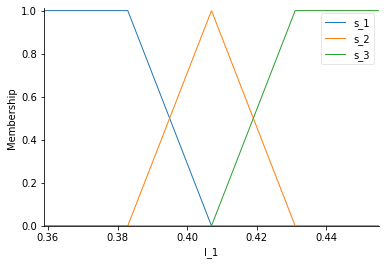

In [ ]:
# plotando os conjuntos para a primeira entrada
antecedents[0].view()

In [ ]:
x1 = .429

In [ ]:
s1 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_1'].mf , x1)
s2 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_2'].mf , x1)
s3 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_3'].mf , x1)

In [ ]:
# O conjunto que representar a maior pertinência será mantido
print(s1, s2, s3)

0.0 0.08523908523908522 0.914760914760915


In [ ]:
 rule1_val.append(s3)
 rule1_set.append("s3")
 print(rule1_val)
 print(rule1_set)

[0.914760914760915]
['s3']


Segundo elemento

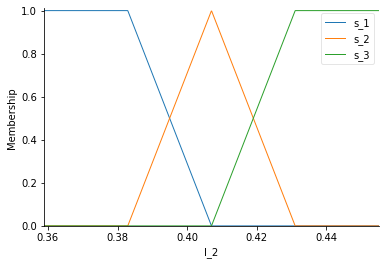

In [ ]:
antecedents[1].view()

In [ ]:
x2 = .443

In [ ]:
s1 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_1'].mf , x2)
s2 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_2'].mf , x2)
s3 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_3'].mf , x2)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule1_val.append(s3)
rule1_set.append("s3")

Terceiro elemento

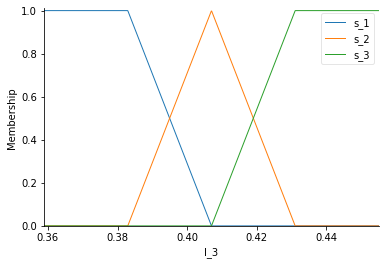

In [ ]:
antecedents[2].view()

In [ ]:
x3 = .451

In [ ]:
s1 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_1'].mf , x3)
s2 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_2'].mf , x3)
s3 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_3'].mf , x3)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule1_val.append(s3)
rule1_set.append("s3")

Quarto elemento

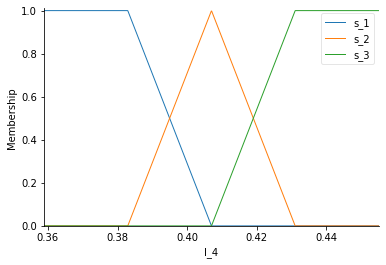

In [ ]:
antecedents[3].view()


In [ ]:
x4 = .455

In [ ]:
s1 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_1'].mf , x4)
s2 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_2'].mf , x4)
s3 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_3'].mf , x4)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule1_val.append(s3)
rule1_set.append("s3")

Quinto elemento

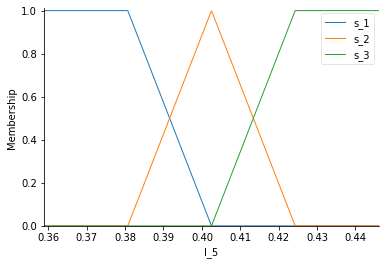

In [ ]:
antecedents[4].view()

In [ ]:
x5 = .44

In [ ]:
s1 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_1'].mf , x5)
s2 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_2'].mf , x5)
s3 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_3'].mf , x5)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule1_val.append(s3)
rule1_set.append("s3")

Sexto Elemento

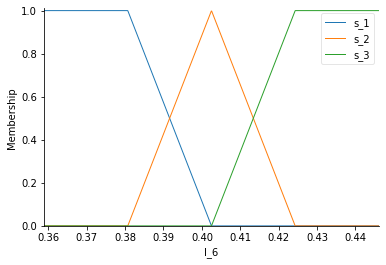

In [ ]:
antecedents[5].view()

In [ ]:
x6 = .433

In [ ]:
s1 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_1'].mf , x6)
s2 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_2'].mf , x6)
s3 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_3'].mf , x6)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule1_val.append(s3)
rule1_set.append("s3")

Sétimo elemento (primeira saída)

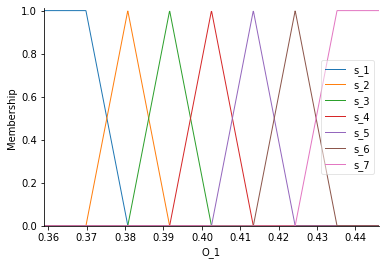

In [ ]:
consequents[0].view()

In [ ]:
x7 = .423

In [ ]:
s1 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_1'].mf ,x7)
s2 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_2'].mf ,x7)
s3 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_3'].mf ,x7)
s4 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_4'].mf ,x7)
s5 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_5'].mf ,x7)
s6 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_6'].mf ,x7)
s7 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_7'].mf ,x7)

print(s1, s2, s3, s4, s5, s6, s7)

0.0 0.0 0.0 0.0 0.11926605504587348 0.8807339449541265 0.0


In [ ]:
rule1_val.append(s6)
rule1_set.append("s6")

In [ ]:
print(rule1_val)
print(rule1_set)

[0.914760914760915, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8807339449541265]
['s3', 's3', 's3', 's3', 's3', 's3', 's6']


In [ ]:
''' 
Para obter o grau da regra basta multiplicar o grau de pertinência 
de cada termo do antecedente e consequente;
'''
Grau1 = np.prod(rule1_val)
Grau1

0.8056609891472262

In [ ]:
df_rules.loc[df_rules["O_1"]=="s_6"]

,I_1,I_2,I_3,I_4,I_5,I_6,O_1,Dr
5,s_1,s_1,s_1,s_2,s_2,s_3,s_6,0.259808
17,s_1,s_2,s_2,s_2,s_3,s_3,s_6,0.226599
37,s_2,s_2,s_3,s_2,s_3,s_3,s_6,0.050193
40,s_2,s_3,s_2,s_2,s_2,s_3,s_6,0.049718
41,s_2,s_3,s_2,s_3,s_3,s_3,s_6,0.050751
54,s_3,s_3,s_2,s_3,s_3,s_3,s_6,0.167324
58,s_3,s_3,s_3,s_3,s_2,s_2,s_6,0.193290


Esta regra não aparece no conjunto de regras. Provavelmente conflitou com outra regra que apresenta grau Dr maior.

## Passo 2

<center>

**j = 1** <br>
</center>
<br>
Janela posicionada do segundo ao setimo elemento, o consequente está associado ao oitavo elemento.



In [ ]:
x1 = .443
x2 = .451
x3 = .455
x4 = .44
x5 = .433
x6 = .423
x7 = .412

In [ ]:
rule2_val = []
rule2_set = []

In [ ]:
s1 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_1'].mf , x1)
s2 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_2'].mf , x1)
s3 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_3'].mf , x1)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule2_val.append(s3)
rule2_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_1'].mf , x2)
s2 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_2'].mf , x2)
s3 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_3'].mf , x2)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule2_val.append(s3)
rule2_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_1'].mf , x3)
s2 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_2'].mf , x3)
s3 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_3'].mf , x3)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule2_val.append(s3)
rule2_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_1'].mf , x4)
s2 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_2'].mf , x4)
s3 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_3'].mf , x4)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule2_val.append(s3)
rule2_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_1'].mf , x5)
s2 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_2'].mf , x5)
s3 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_3'].mf , x5)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule2_val.append(s3)
rule2_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_1'].mf , x6)
s2 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_2'].mf , x6)
s3 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_3'].mf , x6)
print(s1, s2, s3)

0.0 0.05963302752293674 0.9403669724770631


In [ ]:
rule2_val.append(s3)
rule2_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_1'].mf ,x7)
s2 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_2'].mf ,x7)
s3 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_3'].mf ,x7)
s4 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_4'].mf ,x7)
s5 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_5'].mf ,x7)
s6 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_6'].mf ,x7)
s7 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_7'].mf ,x7)

print(s1, s2, s3, s4, s5, s6, s7)

0.0 0.0 0.0 0.12844036697247796 0.871559633027522 0.0 0.0


In [ ]:
rule2_val.append(s5)
rule2_set.append("s5")

In [ ]:
print(rule2_val)
print(rule2_set)

[1.0, 1.0, 1.0, 1.0, 1.0, 0.9403669724770631, 0.871559633027522]
['s3', 's3', 's3', 's3', 's3', 's3', 's5']


In [ ]:
grau2 = np.prod(rule2_val)
grau2

0.819585893443311

In [ ]:
df_rules.loc[df_rules["Dr"]==grau2]

,I_1,I_2,I_3,I_4,I_5,I_6,O_1,Dr
60,s_3,s_3,s_3,s_3,s_3,s_3,s_5,0.819586


Esta regra conflitou com a primeira, como esta apresentou maior DR a mesma será mantida.

## Passo 3

<center>

**j = 2** <br>
</center> <br>
Janela posicionada do terceiro ao oitavo elemento, o consequente está associado ao nono elemento.



In [ ]:
x1 = .451
x2 = .455
x3 = .44
x4 = .433
x5 = .423
x6 = .412
x7 = .411

In [ ]:
rule3_val = []
rule3_set = []

In [ ]:
s1 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_1'].mf , x1)
s2 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_2'].mf , x1)
s3 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_3'].mf , x1)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule3_val.append(s3)
rule3_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_1'].mf , x2)
s2 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_2'].mf , x2)
s3 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_3'].mf , x2)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule3_val.append(s3)
rule3_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_1'].mf , x3)
s2 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_2'].mf , x3)
s3 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_3'].mf , x3)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule3_val.append(s3)
rule3_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_1'].mf , x4)
s2 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_2'].mf , x4)
s3 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_3'].mf , x4)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule3_val.append(s3)
rule3_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_1'].mf , x5)
s2 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_2'].mf , x5)
s3 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_3'].mf , x5)
print(s1, s2, s3)

0.0 0.05963302752293674 0.9403669724770631


In [ ]:
rule3_val.append(s3)
rule3_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_1'].mf , x6)
s2 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_2'].mf , x6)
s3 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_3'].mf , x6)
print(s1, s2, s3)

0.0 0.564220183486239 0.4357798165137596


In [ ]:
rule3_val.append(s2)
rule3_set.append("s2")

In [ ]:
s1 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_1'].mf ,x7)
s2 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_2'].mf ,x7)
s3 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_3'].mf ,x7)
s4 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_4'].mf ,x7)
s5 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_5'].mf ,x7)
s6 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_6'].mf ,x7)
s7 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_7'].mf ,x7)

print(s1, s2, s3, s4, s5, s6, s7)

0.0 0.0 0.0 0.2201834862385329 0.7798165137614671 0.0 0.0


In [ ]:
rule3_val.append(s5)
rule3_set.append("s5")

In [ ]:
print(rule2_val)
print(rule2_set)

[1.0, 1.0, 1.0, 1.0, 1.0, 0.9403669724770631, 0.871559633027522]
['s3', 's3', 's3', 's3', 's3', 's3', 's5']


In [ ]:
grau3 = np.prod(rule3_val)
grau3

0.41375038705696887

Esta regra conflita com outro que possui grau maior, dessa forma a mesma será eliminada.

## Passo 4

<center>

**j = 3** <br>
</center>
<br>
Janela posicionada do quarto ao nono elemento, o consequênte está associado ao décimo elemento.


In [ ]:
x1 = .455
x2 = .44
x3 = .433
x4 = .423
x5 = .412
x6 = .411
x7 = .426

In [ ]:
rule4_val=[]
rule4_set=[]

In [ ]:
s1 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_1'].mf , x1)
s2 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_2'].mf , x1)
s3 = fuzz.interp_membership(antecedents[0].universe, antecedents[0]['s_3'].mf , x1)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule4_val.append(s3)
rule4_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_1'].mf , x2)
s2 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_2'].mf , x2)
s3 = fuzz.interp_membership(antecedents[1].universe, antecedents[1]['s_3'].mf , x2)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule4_val.append(s3)
rule4_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_1'].mf , x3)
s2 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_2'].mf , x3)
s3 = fuzz.interp_membership(antecedents[2].universe, antecedents[2]['s_3'].mf , x3)
print(s1, s2, s3)

0.0 0.0 1.0


In [ ]:
rule4_val.append(s3)
rule4_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_1'].mf , x4)
s2 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_2'].mf , x4)
s3 = fuzz.interp_membership(antecedents[3].universe, antecedents[3]['s_3'].mf , x4)
print(s1, s2, s3)

0.0 0.33471933471933535 0.6652806652806654


In [ ]:
rule4_val.append(s3)
rule4_set.append("s3")

In [ ]:
s1 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_1'].mf , x5)
s2 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_2'].mf , x5)
s3 = fuzz.interp_membership(antecedents[4].universe, antecedents[4]['s_3'].mf , x5)
print(s1, s2, s3)

0.0 0.564220183486239 0.4357798165137596


In [ ]:
rule4_val.append(s2)
rule4_set.append("s2")

In [ ]:
s1 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_1'].mf , x6)
s2 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_2'].mf , x6)
s3 = fuzz.interp_membership(antecedents[5].universe, antecedents[5]['s_3'].mf , x6)
print(s1, s2, s3)

0.0 0.6100917431192664 0.389908256880732


In [ ]:
rule4_val.append(s2)
rule4_set.append("s2")

In [ ]:
s1 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_1'].mf ,x7)
s2 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_2'].mf ,x7)
s3 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_3'].mf ,x7)
s4 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_4'].mf ,x7)
s5 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_5'].mf ,x7)
s6 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_6'].mf ,x7)
s7 = fuzz.interp_membership(consequents[0].universe, consequents[0]['s_7'].mf ,x7)

print(s1, s2, s3, s4, s5, s6, s7)

0.0 0.0 0.0 0.0 0.0 0.8440366972477086 0.1559633027522914


In [ ]:
rule4_val.append(s6)
rule4_set.append("s6")

In [ ]:
print(rule4_val)
print(rule4_set)

[1.0, 1.0, 1.0, 0.6652806652806654, 0.564220183486239, 0.6100917431192664, 0.8440366972477086]
['s3', 's3', 's3', 's3', 's2', 's2', 's6']


In [ ]:
grau4 = np.prod(rule4_val)
grau4

0.19329027170550492

In [ ]:
df_rules.loc[df_rules["Dr"]==grau4]

,I_1,I_2,I_3,I_4,I_5,I_6,O_1,Dr
58,s_3,s_3,s_3,s_3,s_2,s_2,s_6,0.19329


In [ ]:
df_rules.loc[(df_rules["I_1"]=="s_3")&(df_rules["I_2"]=="s_3")&(df_rules["I_3"]=="s_3")&
             (df_rules["I_4"]=="s_3")&(df_rules["I_5"]=="s_2")&(df_rules["I_6"]=="s_2")]

,I_1,I_2,I_3,I_4,I_5,I_6,O_1,Dr
58,s_3,s_3,s_3,s_3,s_2,s_2,s_6,0.19329


Não há conlfito com nenhuma outra regra. Esta regra está mantida até este passo.

Desta forma foi realizada a extração de regras dos dez primeiros dados, sendo possível entender o mecanismo de extração de regras proposto por Mendel e Wang.